##Setting up Enviorment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir("/content/gdrive/My Drive/Object Detection")
!pwd

/content/gdrive/My Drive/Object Detection


# Importing Libraries
 Few important libraries will be:


1.   tensorflow.keras
2.   sklearn
3.   matplotlib
4.   numpy
5.    cv2
6.   scipy.io




In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.io import loadmat
import imutils

# Preprocessing Data

#### Loading Data


> The data set used in this project is [Caltech 101 Dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) which contains thousands of images of 100 different classes along with bounding boxes. For this project only airplanes images are used as this category had the highest number of images.








In [4]:
images_name = os.listdir("airplanes")
images_name.sort()
len(images_name)

800

In [5]:
bound_box_files = os.listdir("airplanes_bbox")
bound_box_files.sort()
len(bound_box_files)

800



> Images are loaded and converted to arrays. Bounding boxes are loaded and then stored in a list in forms of tuples.



In [57]:
bbox = []
images_data = []
for i in range(len(bound_box_files)):
  data = loadmat("airplanes_bbox//" + bound_box_files[i])
  image_path = "airplanes//" + images_name[i]
  (h,w) = cv2.imread(image_path).shape[:2]
  box_coord = data["box_coord"]
  # the coordinates are in the form of (y1, y2, x1, x2)
  # y coordinates are divided by height h
  # x coordinates are divided by width w
  #append them as (x1, y1, x2, y2)
  bbox.append((box_coord[0,2]/w, box_coord[0,0]/h, box_coord[0,3]/w, box_coord[0,1]/h))
  images_data.append(img_to_array(load_img(image_path, target_size = (224,224))))
  print("{}\t{}\t{}".format(images_name[i], bound_box_files[i], bbox[i]))
  
print(len(bbox))
print(len(images_data))

image_0001.jpg	annotation_0001.mat	(0.12311557788944724, 0.18292682926829268, 0.8768844221105527, 0.8353658536585366)
image_0002.jpg	annotation_0002.mat	(0.14713216957605985, 0.19021739130434784, 0.8528678304239401, 0.8315217391304348)
image_0003.jpg	annotation_0003.mat	(0.11959287531806616, 0.21818181818181817, 0.8422391857506362, 0.8181818181818182)
image_0004.jpg	annotation_0004.mat	(0.11959287531806616, 0.1411764705882353, 0.8702290076335878, 0.8294117647058824)
image_0005.jpg	annotation_0005.mat	(0.12151898734177215, 0.10227272727272728, 0.8582278481012658, 0.8295454545454546)
image_0006.jpg	annotation_0006.mat	(0.12213740458015267, 0.16326530612244897, 0.8753180661577609, 0.8571428571428571)
image_0007.jpg	annotation_0007.mat	(0.12531969309462915, 0.1554054054054054, 0.8797953964194374, 0.8243243243243243)
image_0008.jpg	annotation_0008.mat	(0.1291139240506329, 0.19463087248322147, 0.8708860759493671, 0.7986577181208053)
image_0009.jpg	annotation_0009.mat	(0.12755102040816327, 0.


#### Normalizing and Spliting data
> Normalizing will help model in training and then data is splited into train and test categories



In [58]:
# Normalizing and Spliting data

data = np.array(images_data, dtype="float32") / 255.0
targets = np.array(bbox, dtype="float32")

split = train_test_split(data, targets, images_name, test_size=0.10,
	random_state=42)

In [59]:

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

# write the testing filenames to disk so that we can use then
# when evaluating/testing our bounding box regressor
f = open("test_files.txt", "w")
f.write("\n".join(testFilenames))
f.close()
print("testing filenames saved")

testing filenames saved


## Model

In [60]:
#we will be fine-tunning vgg16 model
def get_model():
  vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
  vgg.trainable = False

  flatten = Flatten()(vgg.output)

  head = Dense(128, activation="relu")(flatten)
  head = Dense(64, activation="relu")(head)
  head = Dense(32, activation="relu")(head)
  head = Dense(4, activation="sigmoid")(head)
  model = Model(inputs=vgg.input, outputs=head)
  return model

In [61]:
model = get_model()
opt = Adam(lr=1e-4)
#model is trained with root-square error
model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [62]:
H = model.fit(trainImages, trainTargets, validation_split = 0.10 ,	batch_size=32, epochs=25,	verbose=1)

Epoch 1/25
21/21 [==============================] - 5s 252ms/step - loss: 0.0154 - accuracy: 0.4043 - val_loss: 0.0041 - val_accuracy: 0.1806
Epoch 2/25
21/21 [==============================] - 5s 237ms/step - loss: 0.0020 - accuracy: 0.8735 - val_loss: 0.0010 - val_accuracy: 0.9861
Epoch 3/25
21/21 [==============================] - 5s 238ms/step - loss: 0.0011 - accuracy: 0.9691 - val_loss: 8.3295e-04 - val_accuracy: 0.9583
Epoch 4/25
21/21 [==============================] - 5s 239ms/step - loss: 8.6264e-04 - accuracy: 0.9753 - val_loss: 6.9596e-04 - val_accuracy: 0.9583
Epoch 5/25
21/21 [==============================] - 5s 238ms/step - loss: 7.4700e-04 - accuracy: 0.9799 - val_loss: 6.6374e-04 - val_accuracy: 0.9861
Epoch 6/25
21/21 [==============================] - 5s 238ms/step - loss: 6.3891e-04 - accuracy: 0.9815 - val_loss: 6.6416e-04 - val_accuracy: 0.9861
Epoch 7/25
21/21 [==============================] - 5s 239ms/step - loss: 5.7198e-04 - accuracy: 0.9815 - val_loss: 6.62

In [63]:
# save the model to disk
model.save("object_detection_model.h5", save_format="h5")

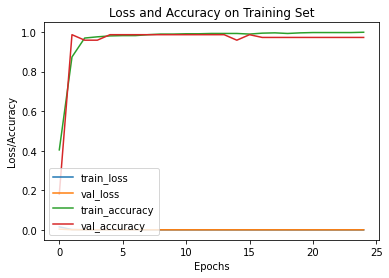

In [64]:
plt.figure()
plt.plot(range(0, 25), H.history["loss"], label="train_loss")
plt.plot(range(0, 25), H.history["val_loss"], label="val_loss")
plt.plot(range(0, 25), H.history["accuracy"], label="train_accuracy")
plt.plot(range(0, 25), H.history["val_accuracy"], label="val_accuracy")
plt.title("Loss and Accuracy on Training Set")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Evaluating Model

In [65]:
model.evaluate(testImages, testTargets)

3/3 [==============================] - 0s 118ms/step - loss: 4.8598e-04 - accuracy: 0.9750


[0.0004859788459725678, 0.9750000238418579]

In [70]:
for test_file in testFilenames[:10]:
 image = load_img("airplanes//" + test_file, target_size=(224, 224))
 image = img_to_array(image) / 255.0
 image = np.expand_dims(image, axis=0)
 #make prediction 
 pred = model.predict(image)[0]
 (startX, startY, endX, endY) = pred
 # load the input image (in OpenCV format), resize it such that it
 # fits on our screen
 image = cv2.imread("airplanes//" + test_file)
 image = imutils.resize(image, width=600)
 (h, w) = image.shape[:2]
 # because we scaled down images in training, we have to scale them up now.
 # dimensions are used for it
 startX = int(startX * w)
 startY = int(startY * h)
 endX = int(endX * w)
 endY = int(endY * h)
 # drawing the predicted bounding box on the image
 cv2.rectangle(image, (startX, startY), (endX, endY),
		(0, 255, 0), 2)
 cv2.imwrite("output//"+ test_file, image)


print("Images written to disk")


Images written to disk


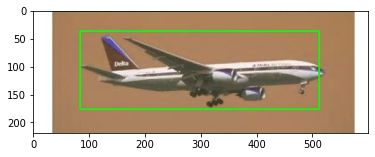

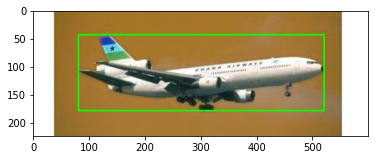

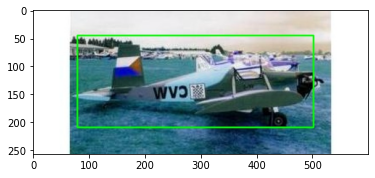

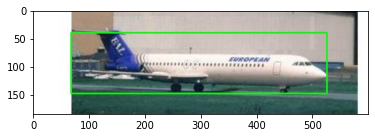

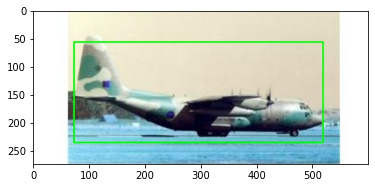

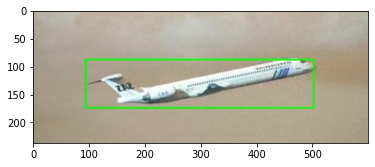

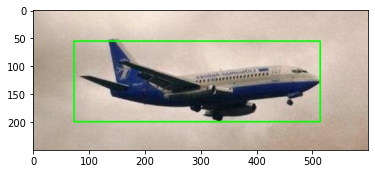

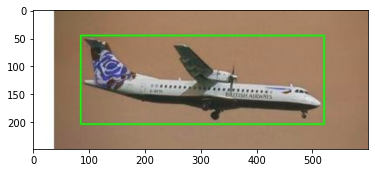

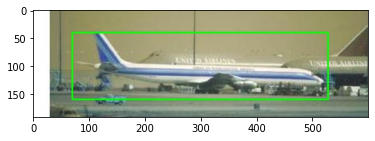

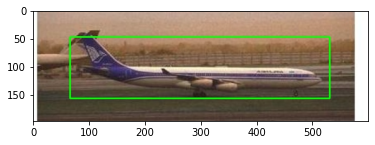

In [72]:
for file in os.listdir("output"):
  image = cv2.imread("output//" + file)
  plt.figure()
  plt.imshow(image)